### The first Support vector Regression model is predicting the closing price only depend on manufacturer



Loading data...
Data merged. Shape: (5998, 15)
Feature Engineering complete. Final dataset shape: (5948, 46)
Training Samples: 5537 | Testing Samples: 411
Training Support Vector Regressor (SVR)...
------------------------------
SVR Model Performance (Test Set > 2023-01-01):
RMSE: $60.79
R² Score: -2.0630
------------------------------


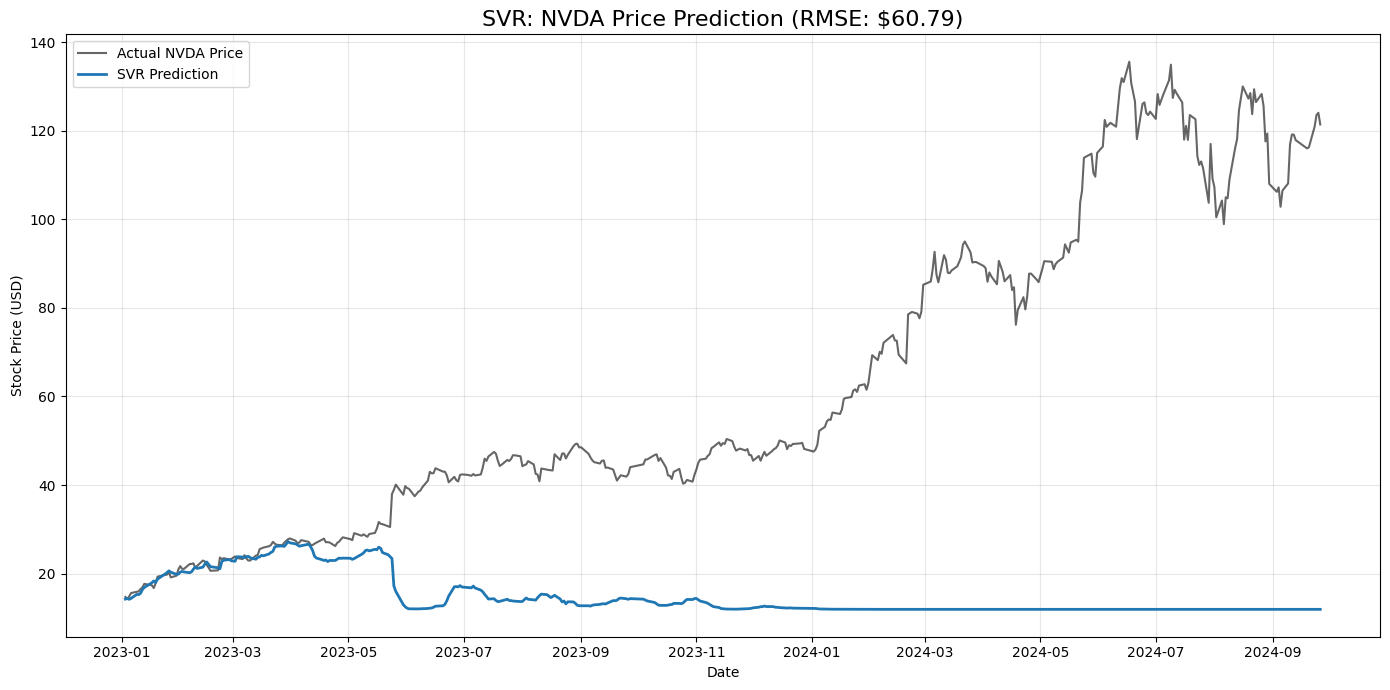

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Loading
def load_data(filepath, prefix):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Adj Close', 'Volume']]
    df.columns = [f'{prefix}_Close', f'{prefix}_Volume']
    return df

print("Loading data...")
nvda = pd.read_csv('NVDA_daily_data.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda.set_index('Date', inplace=True)
nvda = nvda[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
nvda.columns = ['NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume']

tsm = load_data('TSM_daily_data.csv', 'TSM')
asml = load_data('ASML_daily_data.csv', 'ASML')
snps = load_data('SNPS_daily_data.csv', 'SNPS')
cdns = load_data('CDNS_daily_data.csv', 'CDNS')
samsung = load_data('005930.KS_daily_data.csv', 'Samsung')

df = nvda.join([tsm, asml, snps, cdns, samsung], how='inner')
print(f"Data merged. Shape: {df.shape}")

# 2. Feature Engineering
stocks = ['NVDA', 'TSM', 'ASML', 'SNPS', 'CDNS', 'Samsung']

for stock in stocks:
    col = f'{stock}_Close'
    df[f'{col}_Lag1'] = df[col].shift(1)
    df[f'{col}_Lag5'] = df[col].shift(5)
    df[f'{col}_MA10'] = df[col].rolling(window=10).mean()
    df[f'{col}_MA50'] = df[col].rolling(window=50).mean()
    df[f'{col}_Vol20'] = df[col].rolling(window=20).std()

df['Target_NextDay_Price'] = df['NVDA_Close'].shift(-1)
df.dropna(inplace=True)

X = df.drop(columns=['Target_NextDay_Price'])
y = df['Target_NextDay_Price']

print(f"Feature Engineering complete. Final dataset shape: {df.shape}")

# 4. Time Series Split
split_date = '2023-01-01'
X_train = X.loc[:split_date]
X_test = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test = y.loc[split_date:]

print(f"Training Samples: {len(X_train)} | Testing Samples: {len(X_test)}")

# 5. Robust Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Support Vector Regression (SVR) Training
print("Training Support Vector Regressor (SVR)...")
svr = SVR(
    kernel='rbf',
    C=100.0,
    epsilon=1.0,
    gamma='scale'
)
svr.fit(X_train_scaled, y_train)

# 7. Evaluation
predictions = svr.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2   = r2_score(y_test, predictions)

print("-" * 30)
print(f"SVR Model Performance (Test Set > {split_date}):")
print(f"RMSE: ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print("-" * 30)

# 8. Visualization
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual NVDA Price', color='black', alpha=0.6)
plt.plot(y_test.index, predictions, label='SVR Prediction', linewidth=2)
plt.title(f'SVR: NVDA Price Prediction (RMSE: ${rmse:.2f})', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [2]:
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance



Computing permutation-based feature importance (SVR on returns)...

Top Predictors of Daily Return (SVR, permutation importance):
             Feature  Importance
0          NVDA_Open    0.024035
1          NVDA_High    0.023668
2           NVDA_Low    0.023493
15   NVDA_Close_Lag1    0.023489
3         NVDA_Close    0.023320
17   NVDA_Close_MA10    0.022805
16   NVDA_Close_Lag5    0.022336
19  NVDA_Close_Vol20    0.021500
18   NVDA_Close_MA50    0.021316
34  SNPS_Close_Vol20    0.008209


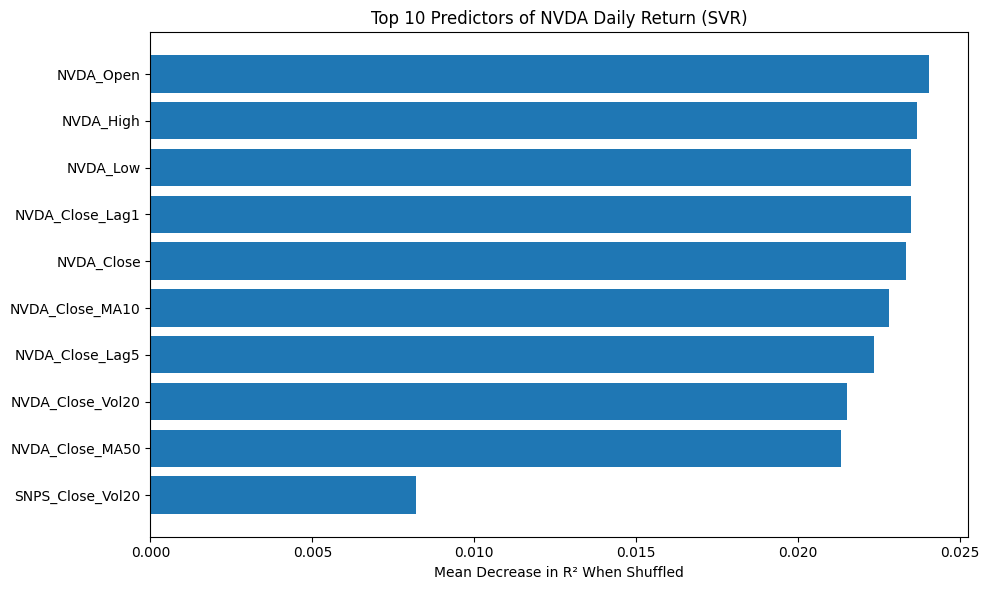

In [3]:
# 10. Feature Importance via Permutation Importance (on returns)
print("\nComputing permutation-based feature importance (SVR on returns)...")

pi_result = permutation_importance(
    svr,
    X_test_scaled,
    y_test.values,   # as array of returns
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pi_result.importances_mean
}).sort_values(by='Importance', ascending=False).head(10)

print("\nTop Predictors of Daily Return (SVR, permutation importance):")
print(feat_imp)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel('Mean Decrease in R² When Shuffled')
plt.title('Top 10 Predictors of NVDA Daily Return (SVR)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Loading data...
Merged shape: (5998, 15)
Train RMSE: 0.42, R²: 0.9946
Test RMSE:  60.79,  R²: -2.0630


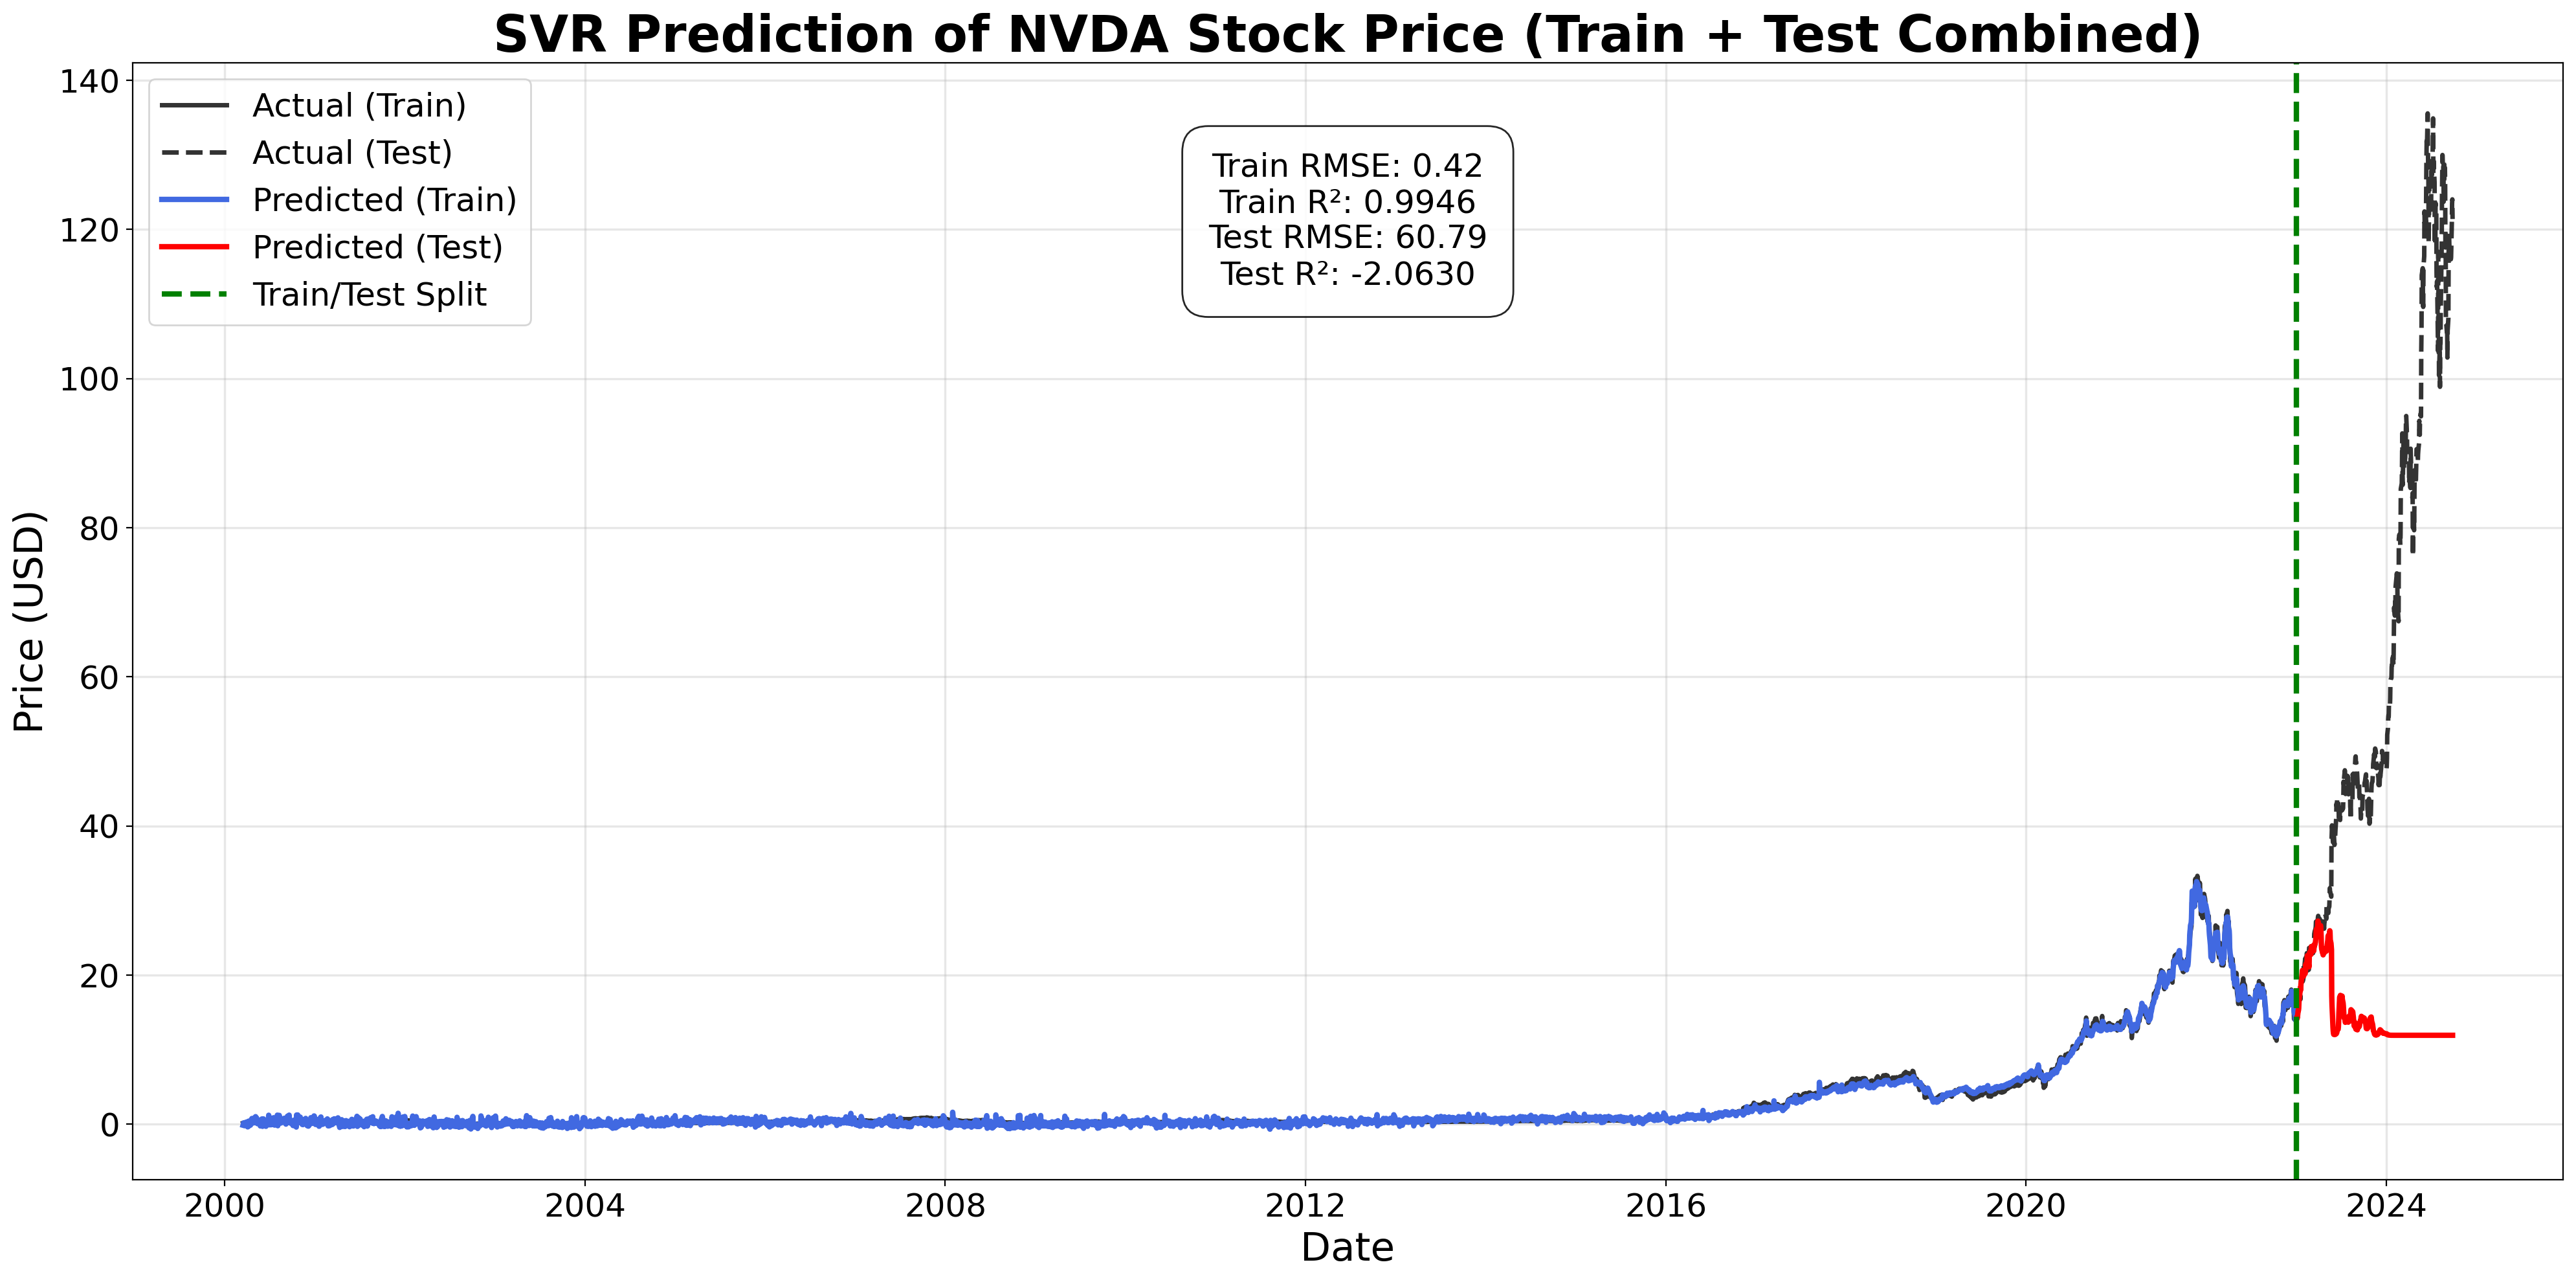

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Loading
def load_data(filepath, prefix):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Adj Close', 'Volume']]
    df.columns = [f'{prefix}_Close', f'{prefix}_Volume']
    return df

print("Loading data...")

# --- Load NVDA (target) ---
nvda = pd.read_csv('NVDA_daily_data.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda.set_index('Date', inplace=True)
nvda = nvda[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
nvda.columns = ['NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume']

# --- Load ecosystem companies ---
tsm     = load_data('TSM_daily_data.csv', 'TSM')
asml    = load_data('ASML_daily_data.csv', 'ASML')
snps    = load_data('SNPS_daily_data.csv', 'SNPS')
cdns    = load_data('CDNS_daily_data.csv', 'CDNS')
samsung = load_data('005930.KS_daily_data.csv', 'Samsung')
msft = load_data('Microsoft Stock Price (All Time).csv', 'MSFT')

# --- Merge all datasets ---
df = nvda.join([tsm, asml, snps, cdns, samsung], how='inner')
print("Merged shape:", df.shape)

# 2. Feature Engineering
stocks =  ['NVDA', 'TSM', 'ASML', 'SNPS', 'CDNS', 'Samsung', 'MSFT']

for stock in stocks:
    col = f"{stock}_Close"
    if col not in df.columns:
        continue
    
    df[f'{col}_Lag1']  = df[col].shift(1)
    df[f'{col}_Lag5']  = df[col].shift(5)
    df[f'{col}_MA10']  = df[col].rolling(10).mean()
    df[f'{col}_MA50']  = df[col].rolling(50).mean()
    df[f'{col}_Vol20'] = df[col].rolling(20).std()

df['Target_NextDay_Price'] = df['NVDA_Close'].shift(-1)
df.dropna(inplace=True)

X = df.drop(columns=['Target_NextDay_Price'])
y = df['Target_NextDay_Price']

# 3. Train/Test Split
split_date = '2023-01-01'
X_train = X.loc[:split_date]
X_test  = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test  = y.loc[split_date:]

# 4. Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5. Model
svr = SVR(kernel='rbf', C=100.0, epsilon=1.0, gamma='scale')
svr.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = svr.predict(X_train_scaled)
y_test_pred  = svr.predict(X_test_scaled)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test,  y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
print(f"Test RMSE:  {test_rmse:.2f},  R²: {test_r2:.4f}")

# --------------------------------------------------------
# 6. HIGH-RES, POWERPOINT-READY COMBINED PLOT + METRICS BOX
# --------------------------------------------------------
plt.figure(figsize=(20, 10), dpi=200)

# Actual train
plt.plot(y_train.index, y_train,
         label='Actual (Train)',
         color='black', linewidth=2.5, alpha=0.8)

# Actual test
plt.plot(y_test.index, y_test,
         label='Actual (Test)',
         color='black', linestyle='--', linewidth=2.5, alpha=0.8)

# Predicted train
plt.plot(y_train.index, y_train_pred,
         label='Predicted (Train)',
         color='royalblue', linewidth=3)

# Predicted test
plt.plot(y_test.index, y_test_pred,
         label='Predicted (Test)',
         color='red', linewidth=3)

# Splitting line
plt.axvline(pd.to_datetime(split_date),
            color='green', linestyle='--',
            linewidth=3, label='Train/Test Split')

# ---------- METRICS BOX (TOP MIDDLE) ----------
metrics_text = (
    f"Train RMSE: {train_rmse:.2f}\n"
    f"Train R²: {train_r2:.4f}\n"
    f"Test RMSE: {test_rmse:.2f}\n"
    f"Test R²: {test_r2:.4f}"
)

plt.text(
    0.50, 0.92, metrics_text,
    transform=plt.gca().transAxes,
    fontsize=18,
    ha='center', va='top',
    bbox=dict(facecolor='white', alpha=0.85, edgecolor='black', boxstyle="round,pad=0.8")
)
# ----------------------------------------------

# Formatting
plt.title("SVR Prediction of NVDA Stock Price (Train + Test Combined)",
          fontsize=28, fontweight='bold')

plt.xlabel("Date", fontsize=22)
plt.ylabel("Price (USD)", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18, loc='upper left')
plt.grid(True, linewidth=1.2, alpha=0.3)

plt.tight_layout()
plt.show()


## Now we add buyer(Microsoft) this time



--- Loading Data ---
Loaded NVDA: 1999-01-22 to 2024-09-27
Loaded TSM: 1997-10-09 to 2024-09-27
Loaded ASML: 1995-03-15 to 2024-09-27
Loaded SNPS: 1992-02-26 to 2024-09-27
Loaded CDNS: 1987-06-10 to 2024-09-27
Loaded Samsung: 2000-01-04 to 2024-09-27
Loaded MSFT: 1986-03-13 to 2021-09-29

Merged Data: 2000-01-04 → 2024-09-27
Total rows: 6223

Split summary:
Train size: 5737
Test size: 436


/scratch/local/19443285/ipykernel_3911142/1917973483.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



Training Support Vector Regression (SVR)...

----------------------------------------
SVR RMSE: $62.94
SVR R²:   -2.2885
----------------------------------------


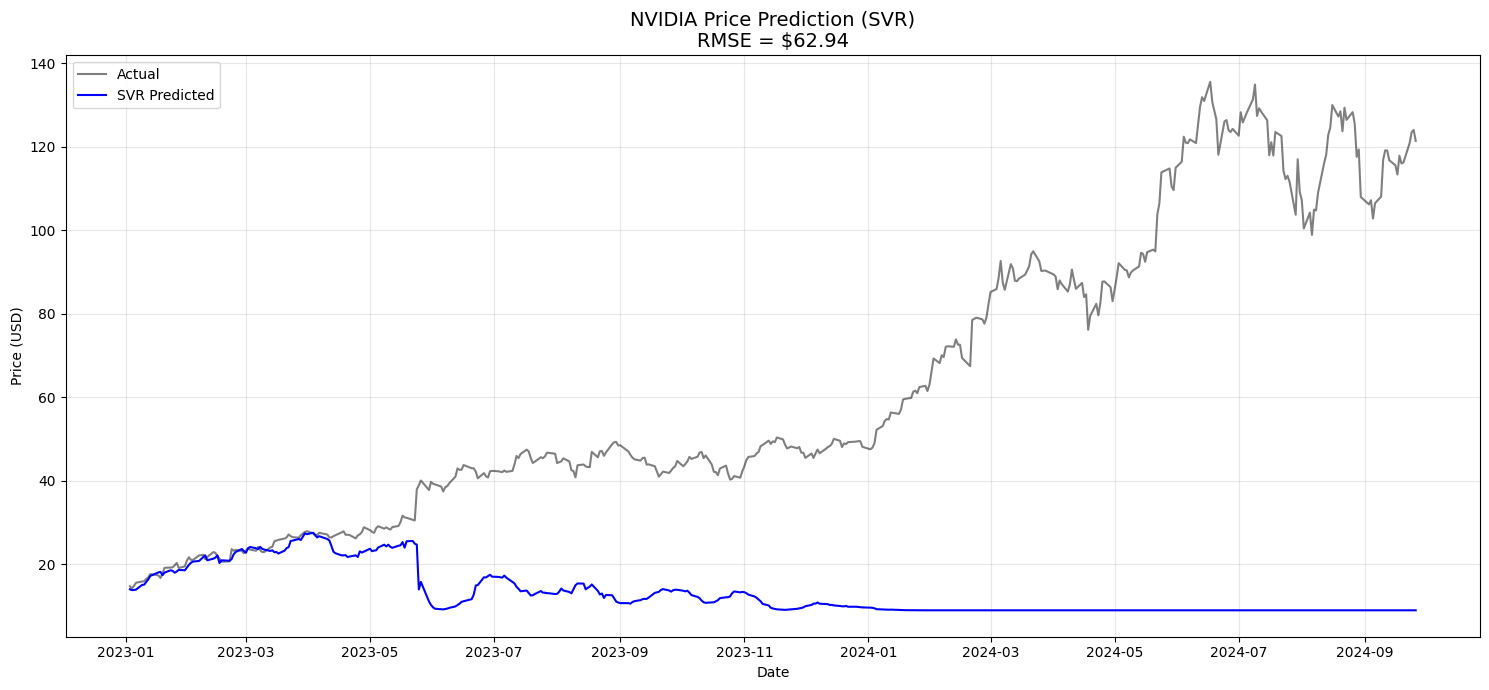


Computing Permutation Importance...

Top 15 Important Features (Permutation Importance):
       Feature  Importance
0    NVDA_Open   48.559641
2     NVDA_Low   48.403071
1    NVDA_High   48.243816
17   NVDA_Lag1   48.158789
3   NVDA_Close   48.095703
19   NVDA_MA10   47.195994
18   NVDA_Lag5   46.678005
21  NVDA_Vol20   44.855472
20   NVDA_MA50   43.846213
39  SNPS_Vol20   13.479494
27   TSM_Vol20   12.892505
45  CDNS_Vol20    6.251400
44   CDNS_MA50    5.820415
33  ASML_Vol20    5.796408
42   CDNS_Lag5    4.280357


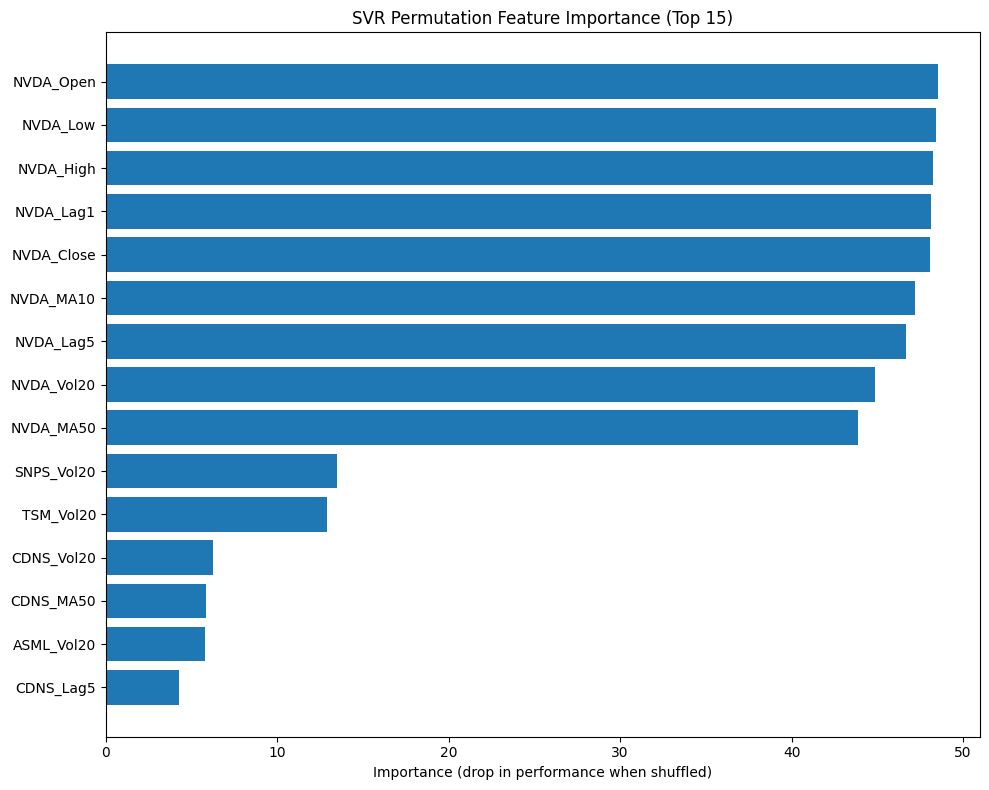

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# -----------------------------
# 1. Data Loading
# -----------------------------
def load_data(filepath, prefix):
    try:
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        col_to_use = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
        df = df[[col_to_use, 'Volume']].copy()
        df.columns = [f'{prefix}_Close', f'{prefix}_Volume']
        df.sort_index(inplace=True)

        print(f"Loaded {prefix}: {df.index.min().date()} to {df.index.max().date()}")
        return df
    except Exception as e:
        print(f"Error loading {prefix}: {e}")
        return pd.DataFrame()


print("\n--- Loading Data ---")

# NVDA (Target)
nvda = pd.read_csv('NVDA_daily_data.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda.set_index('Date', inplace=True)
nvda.sort_index(inplace=True)
nvda = nvda[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
nvda.columns = ['NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume']

print(f"Loaded NVDA: {nvda.index.min().date()} to {nvda.index.max().date()}")

# Ecosystem
tsm = load_data('TSM_daily_data.csv', 'TSM')
asml = load_data('ASML_daily_data.csv', 'ASML')
snps = load_data('SNPS_daily_data.csv', 'SNPS')
cdns = load_data('CDNS_daily_data.csv', 'CDNS')
samsung = load_data('005930.KS_daily_data.csv', 'Samsung')
msft = load_data('Microsoft Stock Price (All Time).csv', 'MSFT')

# -----------------------------
# 2. Merge All
# -----------------------------
dfs_to_merge = [tsm, asml, snps, cdns, samsung, msft]
df = nvda.join(dfs_to_merge, how='left')

df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

print(f"\nMerged Data: {df.index.min().date()} → {df.index.max().date()}")
print("Total rows:", len(df))

# -----------------------------
# 3. Feature Engineering
# -----------------------------
tickers = ['NVDA', 'TSM', 'ASML', 'SNPS', 'CDNS', 'Samsung', 'MSFT']

for ticker in tickers:
    col_price = f'{ticker}_Close'
    if col_price not in df.columns:
        continue

    df[f'{ticker}_Lag1'] = df[col_price].shift(1)
    df[f'{ticker}_Lag5'] = df[col_price].shift(5)

    df[f'{ticker}_MA10'] = df[col_price].rolling(10).mean()
    df[f'{ticker}_MA50'] = df[col_price].rolling(50).mean()

    df[f'{ticker}_Vol20'] = df[col_price].rolling(20).std()
    df[f'{ticker}_Ret'] = df[col_price].pct_change()

df['Target'] = df['NVDA_Close'].shift(-1)
df.dropna(inplace=True)

X = df.drop(columns=['Target'])
y = df['Target']

# -----------------------------
# 4. Train/Test Split
# -----------------------------
split_date = '2023-01-01'

X_train = X.loc[:split_date]
X_test  = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test  = y.loc[split_date:]

print("\nSplit summary:")
print("Train size:", len(X_train))
print("Test size:", len(X_test))

# -----------------------------
# 5. Scaling
# -----------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -----------------------------
# 6. Support Vector Regression (SVR)
# -----------------------------
print("\nTraining Support Vector Regression (SVR)...")

svr = SVR(
    kernel='rbf',
    C=100.0,
    epsilon=1.0,
    gamma='scale'
)

svr.fit(X_train_scaled, y_train)

# -----------------------------
# 7. Evaluation
# -----------------------------
preds = svr.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2   = r2_score(y_test, preds)

print("\n" + "-"*40)
print(f"SVR RMSE: ${rmse:.2f}")
print(f"SVR R²:   {r2:.4f}")
print("-"*40)

# -----------------------------
# 8. Plot Predictions
# -----------------------------
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual', color='black', alpha=0.5)
plt.plot(y_test.index, preds, label='SVR Predicted', color='blue')
plt.title(f'NVIDIA Price Prediction (SVR)\nRMSE = ${rmse:.2f}', fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("svr_prediction_plot.png", dpi=900)
plt.show()

# -----------------------------
# 9. Permutation Feature Importance
# -----------------------------
print("\nComputing Permutation Importance...")

result = permutation_importance(
    svr, X_test_scaled, y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)

perm_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 Important Features (Permutation Importance):")
print(perm_imp.head(15))

plt.figure(figsize=(10, 8))
plt.barh(perm_imp['Feature'].head(15)[::-1],
         perm_imp['Importance'].head(15)[::-1])
plt.xlabel("Importance (drop in performance when shuffled)")
plt.title("SVR Permutation Feature Importance (Top 15)")
plt.tight_layout()
plt.savefig("svr_feature_importance.png", dpi=900)
plt.show()


## Now we predict the percentage change for the closing price




--- Loading Ecosystem Data ---
Merged data from 2000-01-04 to 2024-09-27
Total rows: 6223

Data split:
Train samples: 5766
Test samples:  436

Training SVR on 5766 samples...


/scratch/local/19443285/ipykernel_3911142/988612045.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



----------------------------------------
SVR RETURN-BASED STRATEGY RESULTS
Train RMSE: $0.06
Train R²:   0.9999
Test  RMSE: $3.29
Test  R²:   0.9910
----------------------------------------


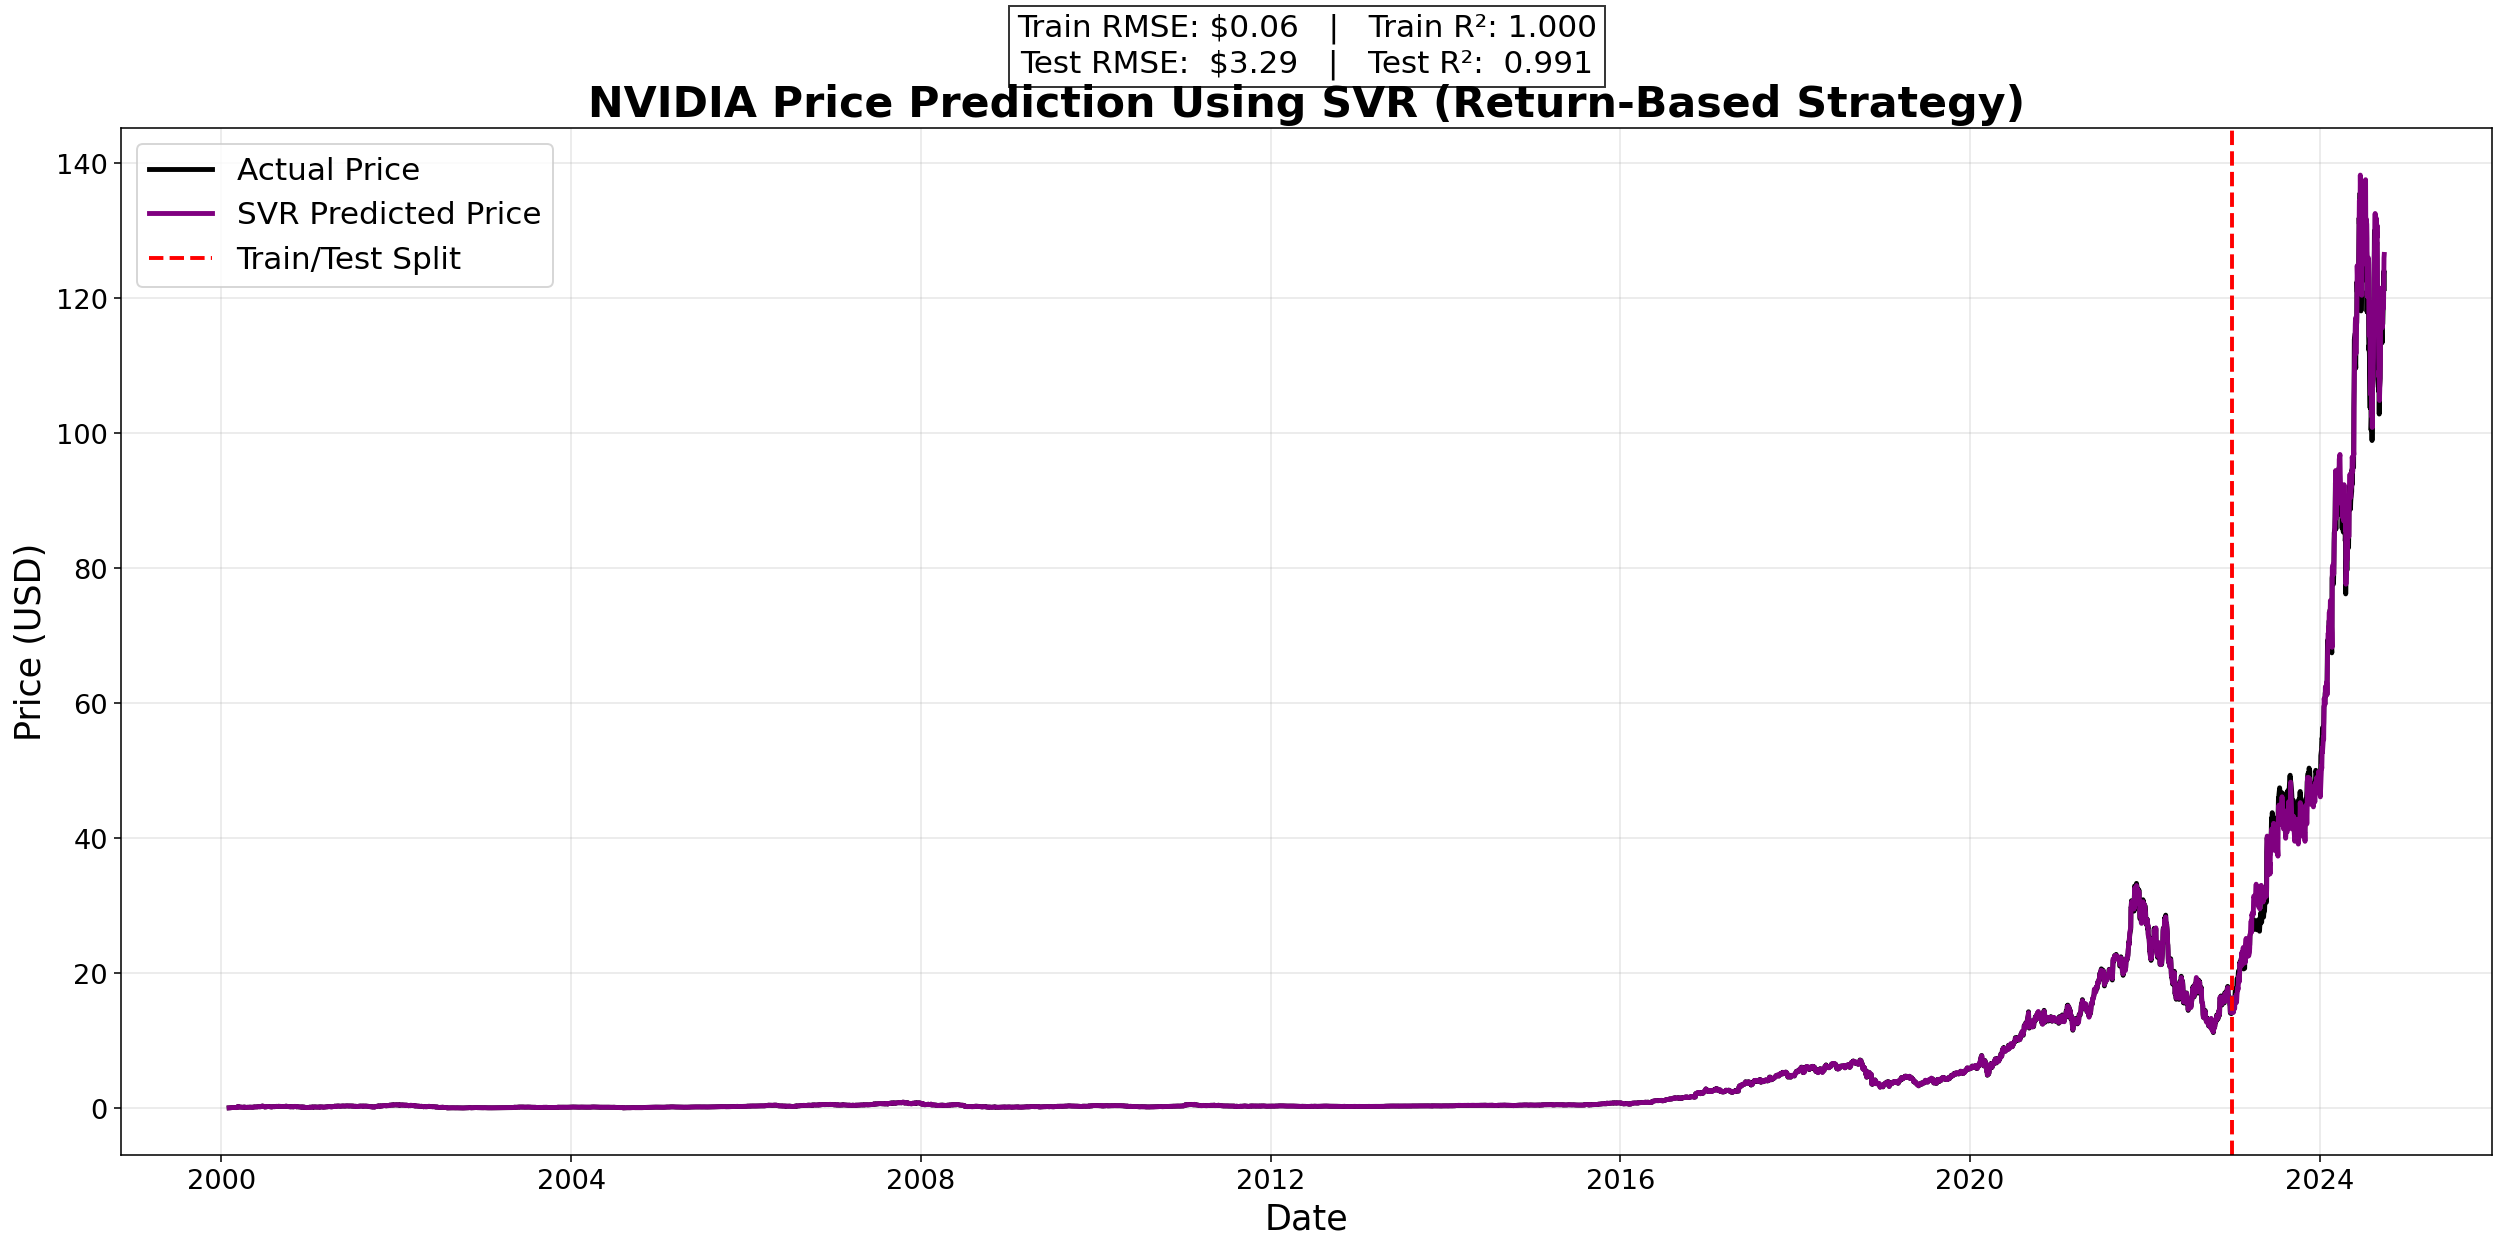

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# 1. Data Loading
def load_data(filepath, prefix):
    try:
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        col_to_use = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
        df = df[[col_to_use, 'Volume']].copy()
        df.columns = [f'{prefix}_Close', f'{prefix}_Volume']
        return df
    except Exception as e:
        print(f"Error loading {prefix}: {e}")
        return pd.DataFrame()

print("--- Loading Ecosystem Data ---")

# NVDA (Target)
nvda = pd.read_csv('NVDA_daily_data.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda.set_index('Date', inplace=True)
nvda = nvda[['Adj Close', 'Volume']]
nvda.columns = ['NVDA_Close', 'NVDA_Volume']

# Load Ecosystem
tsm     = load_data('TSM_daily_data.csv', 'TSM')
asml    = load_data('ASML_daily_data.csv', 'ASML')
snps    = load_data('SNPS_daily_data.csv', 'SNPS')
cdns    = load_data('CDNS_daily_data.csv', 'CDNS')
samsung = load_data('005930.KS_daily_data.csv', 'Samsung')
msft    = load_data('Microsoft Stock Price (All Time).csv', 'MSFT')

# 2. Merge & Fill
dfs = [tsm, asml, snps, cdns, samsung, msft]
df = nvda.join(dfs, how='left')
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

print(f"Merged data from {df.index.min().date()} to {df.index.max().date()}")
print("Total rows:", len(df))

# 3. Feature Engineering (Return-based features)
tickers = ['NVDA', 'TSM', 'ASML', 'SNPS', 'CDNS', 'Samsung', 'MSFT']

for ticker in tickers:
    col = f'{ticker}_Close'
    if col not in df.columns:
        continue
    
    # 1. Daily Returns
    df[f'{ticker}_Ret'] = df[col].pct_change()
    
    # 2. Volatility (20-day rolling std of returns)
    df[f'{ticker}_Vol20'] = df[col].pct_change().rolling(window=20).std()
    
    # 3. Moving Average ratio (trend, scale-free)
    df[f'{ticker}_MA10_Ratio'] = df[col].rolling(window=10).mean() / df[col]

# 4. Define NEW Target: Predict tomorrow's % return for NVDA
df['Target_Return'] = df['NVDA_Close'].pct_change().shift(-1)

# Drop NaNs from rolling windows and shifts
df.dropna(inplace=True)

# Define features and target
X = df.drop(columns=['Target_Return'])
y = df['Target_Return']

# 5. Train/Test Split
split_date = '2023-01-01'
X_train = X.loc[:split_date]
X_test  = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test  = y.loc[split_date:]

print("\nData split:")
print("Train samples:", len(X_train))
print("Test samples: ", len(X_test))

# We'll need today's NVDA price to reconstruct tomorrow's price
train_prices_today = X_train['NVDA_Close']
test_prices_today  = X_test['NVDA_Close']

# 6. Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 7. Train SVR on Returns
print(f"\nTraining SVR on {len(X_train)} samples...")
svr = SVR(
    kernel='rbf',
    C=100.0,       # can tune later
    epsilon=0.01,  # small epsilon for return prediction
    gamma='scale'
)
svr.fit(X_train_scaled, y_train)

# 8. Predict Returns & Reconstruct Prices

# --- Train predictions ---
train_pred_returns = svr.predict(X_train_scaled)
train_pred_prices  = train_prices_today * (1 + train_pred_returns)
train_actual_prices = train_prices_today * (1 + y_train)

# --- Test predictions ---
test_pred_returns = svr.predict(X_test_scaled)
test_pred_prices  = test_prices_today * (1 + test_pred_returns)
test_actual_prices = test_prices_today * (1 + y_test)

# 9. Evaluation on Price Level
train_rmse = np.sqrt(mean_squared_error(train_actual_prices, train_pred_prices))
train_r2   = r2_score(train_actual_prices, train_pred_prices)

test_rmse  = np.sqrt(mean_squared_error(test_actual_prices, test_pred_prices))
test_r2    = r2_score(test_actual_prices, test_pred_prices)

print("\n" + "-" * 40)
print("SVR RETURN-BASED STRATEGY RESULTS")
print(f"Train RMSE: ${train_rmse:.2f}")
print(f"Train R²:   {train_r2:.4f}")
print(f"Test  RMSE: ${test_rmse:.2f}")
print(f"Test  R²:   {test_r2:.4f}")
print("-" * 40)

# 10. Build combined series for plotting (train + test in one plot)
combined_actual = pd.concat([train_actual_prices, test_actual_prices]).sort_index()
combined_pred   = pd.concat([train_pred_prices,  test_pred_prices]).sort_index()



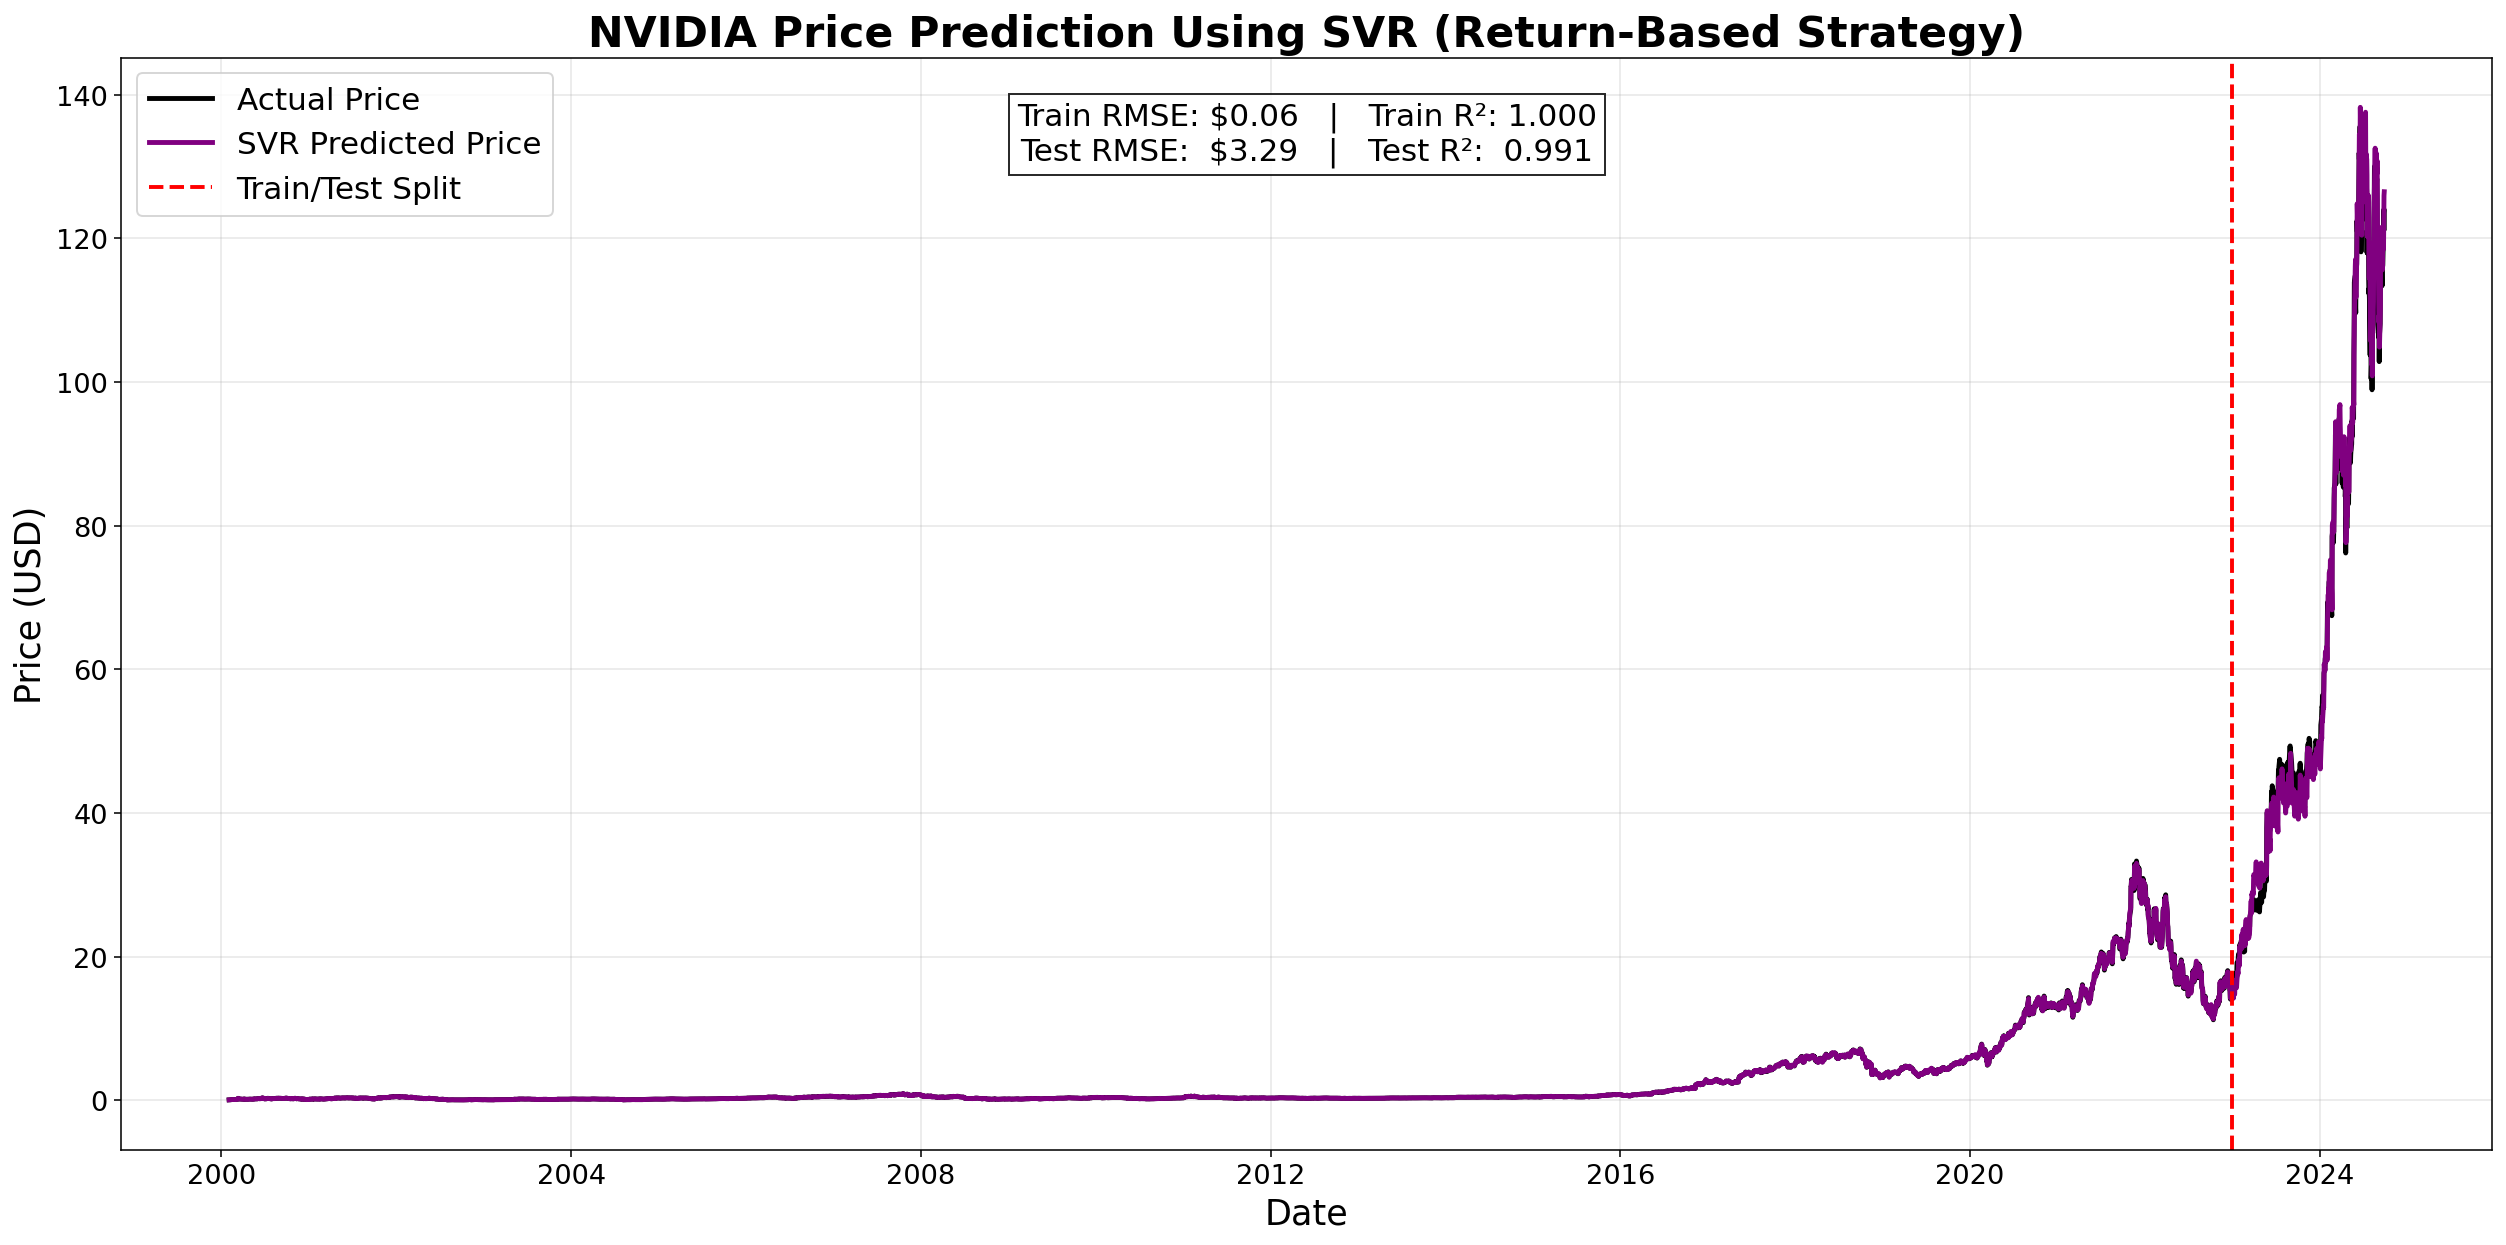

In [19]:
# 11. High-Quality Plot for PowerPoint (Train + Test)
fig, ax = plt.subplots(figsize=(18, 9), dpi=140)   # bigger & sharper

# Actual prices
ax.plot(
    combined_actual.index, combined_actual,
    label='Actual Price',
    color='black',
    linewidth=2.5
)

# Predicted prices
ax.plot(
    combined_pred.index, combined_pred,
    label='SVR Predicted Price',
    color='purple',
    linewidth=2.5
)

# Train/Test split vertical line
ax.axvline(
    pd.to_datetime(split_date),
    color='red',
    linestyle='--',
    linewidth=2,
    label='Train/Test Split'
)

# Title
ax.set_title(
    'NVIDIA Price Prediction Using SVR (Return-Based Strategy)',
    fontsize=22,
    fontweight='bold'
)

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Price (USD)', fontsize=18)

ax.tick_params(labelsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=16, frameon=True)

# ⭐ METRICS BOX (Inside the plot, centered at top)
metrics_text = (
    f"Train RMSE: ${train_rmse:.2f}   |   Train R²: {train_r2:.3f}\n"
    f"Test RMSE:  ${test_rmse:.2f}   |   Test R²:  {test_r2:.3f}"
)

ax.text(
    0.5, 0.93,                   # inside plot: centered horizontally, near top
    metrics_text,
    transform=ax.transAxes,
    fontsize=16,
    ha='center', va='center',
    bbox=dict(facecolor='white', alpha=0.85, edgecolor='black')
)

plt.tight_layout()
plt.show()


## Predicting the stock price will go "Up" (1) or "Down" (0) on the next trading day



--- Loading Data ---


/scratch/local/19443285/ipykernel_3911142/614351828.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Class Balance (Up vs Down):
Target_Class
1    0.517169
0    0.482831
Name: proportion, dtype: float64

Training SVC classifier...

CLASSIFICATION REPORT (SVC)
              precision    recall  f1-score   support

           0       0.42      0.55      0.47       190
           1       0.54      0.40      0.46       247

    accuracy                           0.47       437
   macro avg       0.48      0.48      0.47       437
weighted avg       0.48      0.47      0.47       437

ROC-AUC Score (SVC): 0.4878

Computing permutation importance for SVC...


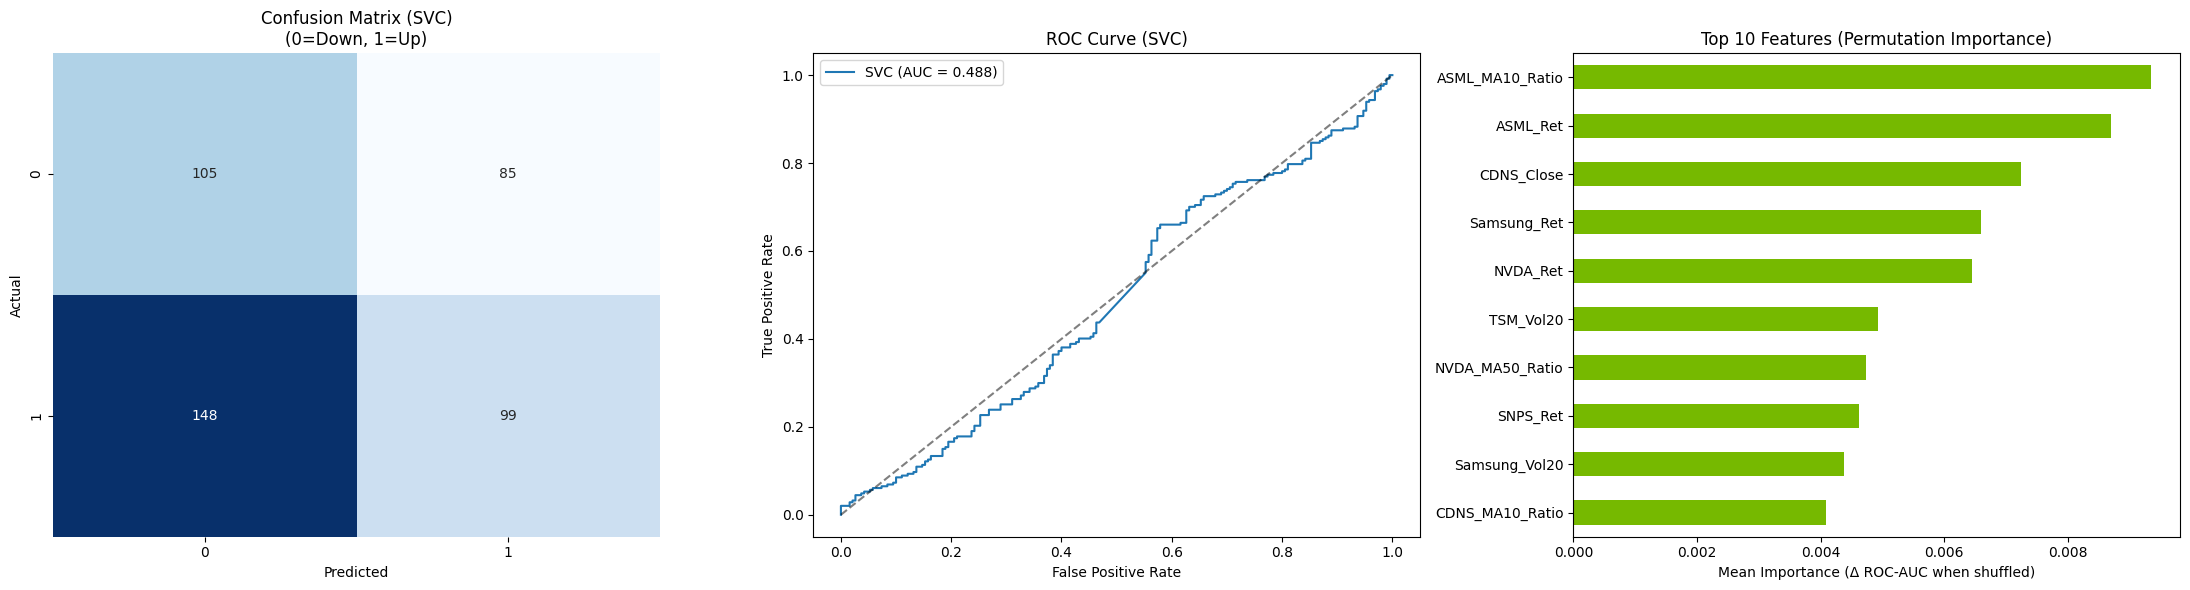

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.inspection import permutation_importance

# 1. Data Loading
def load_data(filepath, prefix):
    try:
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        col_to_use = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
        df = df[[col_to_use, 'Volume']].copy()
        df.columns = [f'{prefix}_Close', f'{prefix}_Volume']
        return df
    except Exception as e:
        print(f"Error loading {prefix}: {e}")
        return pd.DataFrame()

print("--- Loading Data ---")
nvda = pd.read_csv('NVDA_daily_data.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda.set_index('Date', inplace=True)
nvda = nvda[['Adj Close', 'Volume']]
nvda.columns = ['NVDA_Close', 'NVDA_Volume']

# Load Ecosystem
tsm     = load_data('TSM_daily_data.csv', 'TSM')
asml    = load_data('ASML_daily_data.csv', 'ASML')
snps    = load_data('SNPS_daily_data.csv', 'SNPS')
cdns    = load_data('CDNS_daily_data.csv', 'CDNS')
samsung = load_data('005930.KS_daily_data.csv', 'Samsung')
msft    = load_data('Microsoft Stock Price (All Time).csv', 'MSFT')

# Merge & Fill
dfs = [tsm, asml, snps, cdns, samsung, msft]
df = nvda.join(dfs, how='left')
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# 2. Feature Engineering
tickers = ['NVDA', 'TSM', 'ASML', 'SNPS', 'CDNS', 'Samsung', 'MSFT']

for ticker in tickers:
    col = f'{ticker}_Close'
    if col not in df.columns:
        continue
    
    # Momentum (Daily Return)
    df[f'{ticker}_Ret'] = df[col].pct_change()
    
    # Volatility (Risk)
    df[f'{ticker}_Vol20'] = df[col].pct_change().rolling(window=20).std()
    
    # Trend (Moving Average Ratios)
    df[f'{ticker}_MA10_Ratio'] = df[col].rolling(window=10).mean() / df[col]
    df[f'{ticker}_MA50_Ratio'] = df[col].rolling(window=50).mean() / df[col]

# 3. Create Classification Target (Up vs Down)
next_day_ret = df['NVDA_Close'].pct_change().shift(-1)
df['Target_Class'] = (next_day_ret > 0).astype(int)

# Drop NaNs from rolling windows and shift
df.dropna(inplace=True)

# Define X and y
X = df.drop(columns=['Target_Class'])
y = df['Target_Class']

print(f"Class Balance (Up vs Down):\n{y.value_counts(normalize=True)}")

# 4. Train/Test Split
split_date = '2023-01-01'
X_train = X.loc[:split_date]
X_test  = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test  = y.loc[split_date:]

# 5. Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 6. Train Support Vector Classifier (SVC)
print("\nTraining SVC classifier...")
svc = SVC(
    kernel='rbf',
    C=10.0,              # can be tuned
    gamma='scale',
    probability=True,    # needed for predict_proba (for ROC-AUC)
    class_weight=None,   # or 'balanced' if classes are very imbalanced
    random_state=42
)
svc.fit(X_train_scaled, y_train)

# 7. Evaluation
pred_classes = svc.predict(X_test_scaled)
pred_probs   = svc.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*40)
print("CLASSIFICATION REPORT (SVC)")
print("="*40)
print(classification_report(y_test, pred_classes))

print(f"ROC-AUC Score (SVC): {roc_auc_score(y_test, pred_probs):.4f}")

# 8. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(22, 6))

# A. Confusion Matrix
cm = confusion_matrix(y_test, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title('Confusion Matrix (SVC)\n(0=Down, 1=Up)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# B. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
ax[1].plot(fpr, tpr, label=f"SVC (AUC = {roc_auc_score(y_test, pred_probs):.3f})")
ax[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax[1].set_title("ROC Curve (SVC)")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()

# C. "Feature Importance" via Permutation Importance
print("\nComputing permutation importance for SVC...")
result = permutation_importance(
    svc,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

feat_imp = pd.Series(
    result.importances_mean,
    index=X.columns
).sort_values(ascending=False).head(10)

feat_imp.sort_values().plot(kind='barh', ax=ax[2], color='#76b900')
ax[2].set_title('Top 10 Features (Permutation Importance)')
ax[2].set_xlabel('Mean Importance (Δ ROC-AUC when shuffled)')

plt.tight_layout()
plt.show()
